In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
# Ref: 
# https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html
# https://github.com/karthikj89/humanpdac/blob/master/src/3.topicAnalysis.ipynb (Hwang et al., Nat Genet)
# https://github.com/fjrossello/Ratnayake_et_al_2020_SC/blob/main/Trajectory_Analysis.ipynb (Ratneyake et al., Nature)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
#results_file = './write/adm2.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.0
cloudpickle         2.2.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2022.02.0
dateutil            2.8.2
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fsspec              2022.11.0
h5py                3.7.0
igraph              0.9.10
ipykernel           5.5.5
ipython_genutils    0.2.0
jedi                0.18.2
jinja2              3.1.2
joblib              1.1.1
jupyter_server      1.23.3
kiwisolver          1.4.2
llvmlite            0.39.1
louvain             0.7.1
markupsafe          2.1.1
matplotlib          3.5.2
mkl                 2.4.0
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
numba               0.56.4
numexpr             2.8.4
numpy               1.21.5
packaging       

In [3]:
# to avoid load data error, always make sure both anaconda and jupyter was launched at the same working directory
import os
os.getcwd()

'/homevol/huemail/projects/PDAC_non_malignant_cell_types/data/PAGA'

In [7]:
adata = sc.read_h5ad('adm_n4_Nov24.h5ad') # PCA was never transferred/imported to h5ad

In [8]:
adata # this dataset remove ambiguous PDAC with no CNV changes 

AnnData object with n_obs × n_vars = 12748 × 26788
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'scDblFinder.sample', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'subsets_ribo_sum', 'subsets_ribo_detected', 'subsets_ribo_percent', 'total', 'aggregation_order', 'Cell_Ids', 'S_CB', 'cell_class', 'Patient_ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'SCT_snn_res.1.1', 'SCT_snn_res.1.2', 'seurat_clusters', 'simspec_cell_class', 'infercnv_subcluster', 'top_loss', 'top_dup', 'chr12_25245351_G', 'MUT', 'MUT_state', 'ICGC_ID', 'Lv.2.Anno', 'Lv.1.Anno'
    var: 'features'
    obsm: 'X_umap_css'

In [9]:
adata.X = adata.X.astype('float64')

In [10]:
# 7 colors
adata.uns['Lv.2.Anno_colors'] = ["#D76C7C","#5E7D9A", "#DCC179", "#1B9E77","#7F9F32","#6A3D9A","#D2A5DE"]

In [11]:
# Preprocessing, as we only import 
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [12]:
sc.pp.log1p(adata) 

In [13]:
adata.raw = adata #setting raw attribute to AnnData object to the normalised and logarithmmized raw gene expression 

In [14]:
# Calculate PCA and UMAP
sc.tl.pca(adata) #, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:28)


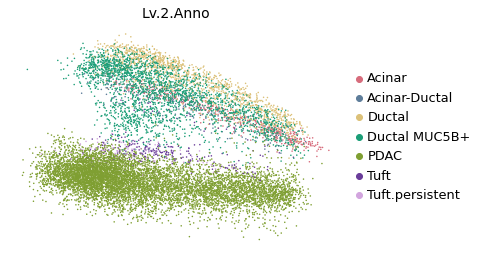

In [15]:
sc.pl.pca(adata, color= 'Lv.2.Anno') # plot confirm succesful transfer using Seurat PCA

In [16]:
#sc.pl.pca(adata, color= 'cell_names') # calculate PCA using scanpy
adata.obs['Lv.2.Anno']

5_CATCCACGTGGTCCGT-1     PDAC
5_GAACGGACAGTCAGCC-1     PDAC
5_CGGACTGTCAGTTGAC-1     PDAC
5_CACCAGGTCCTTTCTC-1     PDAC
5_TGCCAAACACCAGATT-1     PDAC
                         ... 
20_TTCTTAGAGCTCAACT-1    PDAC
20_TACGGGCGTTTGCATG-1    PDAC
20_CCTTTCTCAGGACCCT-1    PDAC
20_AACTGGTCATGACATC-1    PDAC
20_CCCATACGTGACCAAG-1    PDAC
Name: Lv.2.Anno, Length: 12748, dtype: category
Categories (7, object): ['Acinar', 'Acinar-Ductal', 'Ductal', 'Ductal MUC5B+', 'PDAC', 'Tuft', 'Tuft.persistent']

In [17]:
# Computing neighbourhood graph, default setting is UMAP
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


In [18]:
# Diffuse map
sc.tl.diffmap(adata, n_comps=15)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99961483 0.9993284  0.9988724  0.9982266  0.996708
     0.9960898  0.9957209  0.99154687 0.98961306 0.9863781  0.98613995
     0.9845825  0.98390377 0.98148763]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


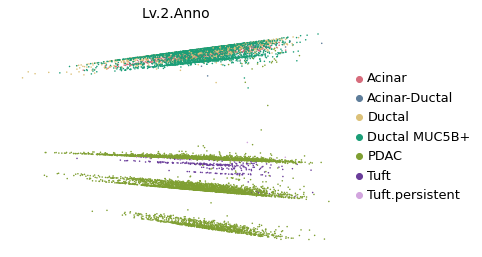

In [19]:
sc.pl.diffmap(adata, color= 'Lv.2.Anno')

In [20]:
#PAGA
sc.tl.paga(adata, groups='Lv.2.Anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 12748 × 26788
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'scDblFinder.sample', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'subsets_ribo_sum', 'subsets_ribo_detected', 'subsets_ribo_percent', 'total', 'aggregation_order', 'Cell_Ids', 'S_CB', 'cell_class', 'Patient_ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'SCT_snn_res.1.1', 'SCT_snn_res.1.2', 'seurat_clusters', 'simspec_cell_class', 'infercnv_subcluster', 'top_loss', 'top_dup', 'chr12_25245351_G', 'MUT', 'MUT_state', 'ICGC_ID', 'Lv.2.Anno', 'Lv.1.Anno'
    var: 'features'
    uns: 'Lv.2.Anno_colors', 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'Lv.2.Anno_sizes'
    obs

--> added 'pos', the PAGA positions (adata.uns['paga'])


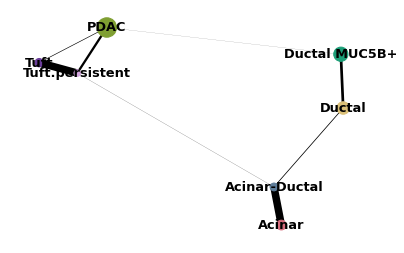

--> added 'pos', the PAGA positions (adata.uns['paga'])


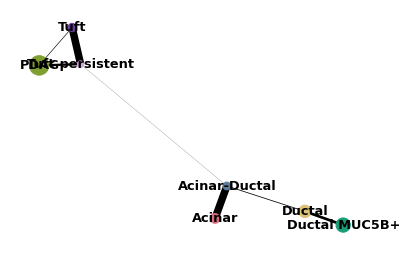

--> added 'pos', the PAGA positions (adata.uns['paga'])


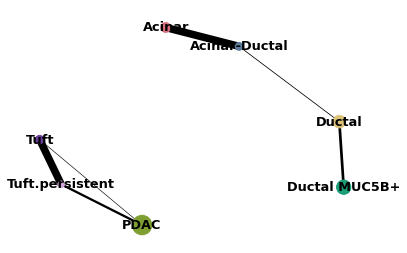

--> added 'pos', the PAGA positions (adata.uns['paga'])


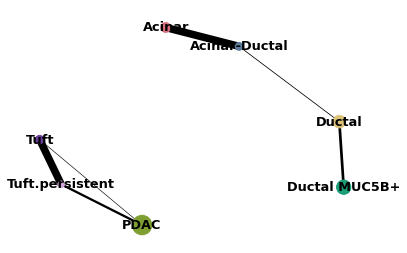

--> added 'pos', the PAGA positions (adata.uns['paga'])


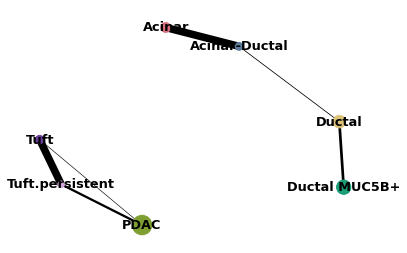

--> added 'pos', the PAGA positions (adata.uns['paga'])


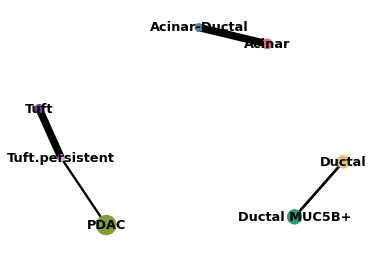

--> added 'pos', the PAGA positions (adata.uns['paga'])


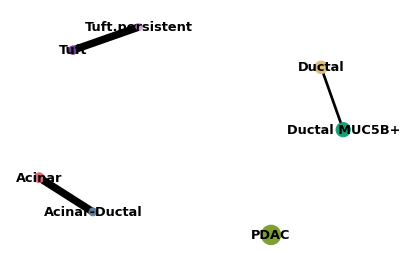

--> added 'pos', the PAGA positions (adata.uns['paga'])


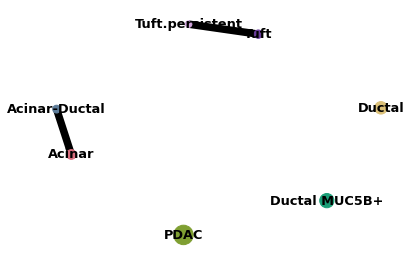

--> added 'pos', the PAGA positions (adata.uns['paga'])


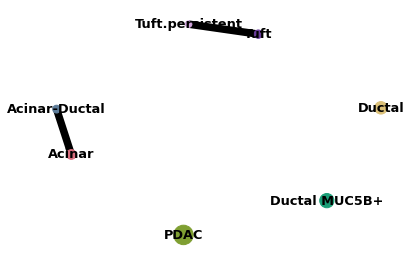

In [22]:
for t in [.01, .02, 0.03, .05, .08, .16, .35, .4, .85]:
    sc.pl.paga(adata,threshold=t, node_size_scale = .6,  frameon=False)

--> added 'pos', the PAGA positions (adata.uns['paga'])


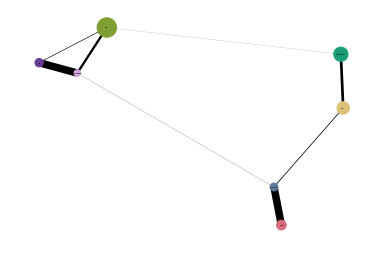

In [26]:
sc.pl.paga(adata, color=['Lv.2.Anno'],threshold=0.01, node_size_scale = .6,  frameon=False, fontsize = 0) #, save = 'paga.pdf')

--> added 'pos', the PAGA positions (adata.uns['paga'])


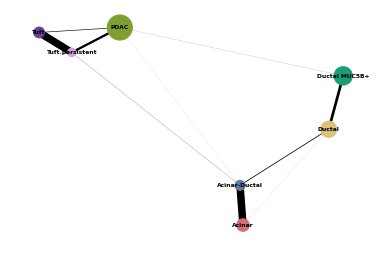

In [34]:
sc.pl.paga(adata, color=['Lv.2.Anno'], threshold=0.005, fontsize = 6, 
           save = 'paga_adm_n4_Nov24.pdf'
          )

In [27]:
sc.tl.umap(adata, init_pos = "paga")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


--> added 'pos', the PAGA positions (adata.uns['paga'])


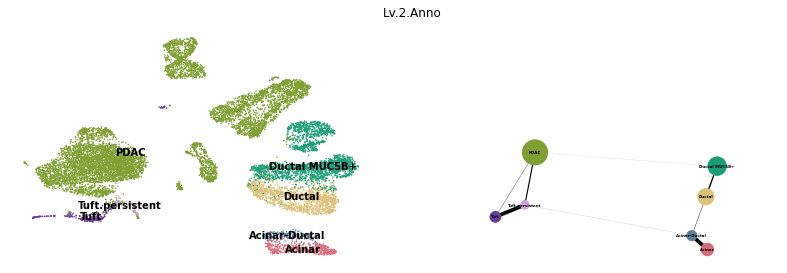

In [28]:
sc.pl.paga_compare(
  adata,
  basis = "umap",
  threshold = 0.01,
  edge_width_scale = 0.5,
  fontsize = 4
  #save = TRUE
)

In [29]:
# Saving results
adata.write('Trajectory_ADM_n4_final.h5ad') # Results are quite similar for both PCA calculated from Seurat or by Scanpy